# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Model street networks and other geospatial features anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Documentation](https://osmnx.readthedocs.io/)
  - [Journal article and citation info](https://geoffboeing.com/publications/osmnx-paper/)
  - [Code repository](https://github.com/gboeing/osmnx)
  - [Examples gallery](https://github.com/gboeing/osmnx-examples)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [1]:
import networkx as nx
import osmnx as ox

ox.__version__

'2.0.1'

## Working with street networks

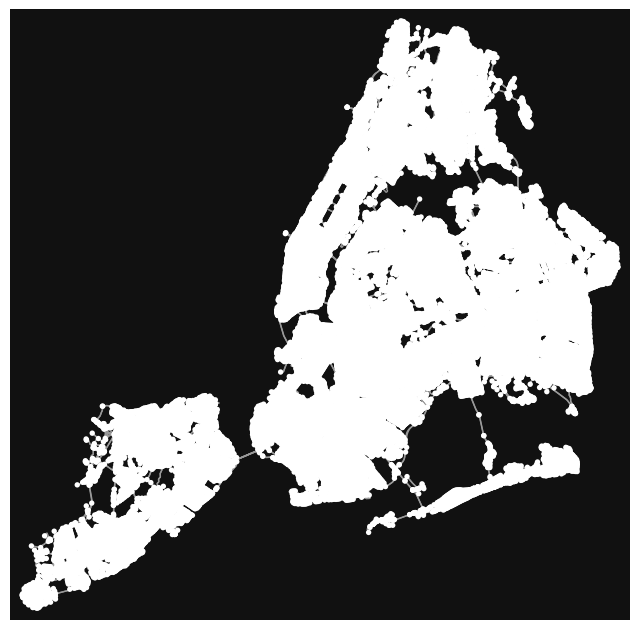

In [26]:
# download/model a street network for some city then visualize it
G = ox.graph.graph_from_place("New York, New York, USA", network_type="drive")
fig, ax = ox.plot.plot_graph(G)

OSMnx geocodes the query "New York, New York, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

Note that converting to an undirected MultiGraph is really only meant for use cases where a function or algorithm only accepts a MultiGraph argument. If you just want a fully bidirectional graph (such as for a walking network), just configure the `settings` module’s `bidirectional_network_types` before creating your graph.

In [27]:
len(G.nodes), len(G.edges)

(55236, 139289)

In [28]:
# # get a fully bidirection network (as a MultiDiGraph)
# ox.settings.bidirectional_network_types += "drive"
# G = ox.graph.graph_from_place("Manhattan, New York, USA", network_type="drive")

# # convert your MultiDiGraph to an undirected MultiGraph
# M = ox.convert.to_undirected(G)

# # convert your MultiDiGraph to a DiGraph without parallel edges
# D = ox.convert.to_digraph(G)

In [29]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,highway,ref,street_count,junction,railway,geometry
osmid,,,,,,,,
39076461,40.786345,-73.794748,motorway_junction,33,3,NaN,NaN,POINT (-73.79475 40.78635)
39076490,40.762429,-73.757091,motorway_junction,31W,3,NaN,NaN,POINT (-73.75709 40.76243)
39076504,40.753467,-73.744164,motorway_junction,30W,3,NaN,NaN,POINT (-73.74416 40.75347)
42421728,40.798048,-73.960044,traffic_signals,NaN,3,NaN,NaN,POINT (-73.96004 40.79805)
42421731,40.798654,-73.961474,traffic_signals,NaN,4,NaN,NaN,POINT (-73.96147 40.79865)


You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge ShapeFiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [ ]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.convert.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

## Basic street network stats

In [14]:
# what sized area does our network cover in square meters?
G_proj = ox.projection.project_graph(G)
nodes_proj = ox.convert.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.union_all().convex_hull.area
graph_area_m

85331687.57542242

In [15]:
# show some basic stats about the network
ox.stats.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 4607,
 'm': 9888,
 'k_avg': 4.2925982200998485,
 'edge_length_total': 1175642.982423563,
 'edge_length_avg': 118.89593268846713,
 'streets_per_node_avg': 3.5519861080963753,
 'streets_per_node_counts': {0: 0, 1: 102, 2: 28, 3: 1768, 4: 2643, 5: 66},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.02214022140221402,
  2: 0.006077707835901888,
  3: 0.3837638376383764,
  4: 0.5736922075103104,
  5: 0.014326025613197308},
 'intersection_count': 4505,
 'street_length_total': 992289.3629539646,
 'street_segment_count': 8168,
 'street_length_avg': 121.48498567017197,
 'circuity_avg': 1.0203175705539222,
 'self_loop_proportion': 0.0009794319294809011,
 'clean_intersection_count': 3645,
 'node_density_km': 53.98932250024933,
 'intersection_density_km': 52.79398694673827,
 'edge_density_km': 13777.331913006446,
 'street_density_km': 11628.61524421284,
 'clean_intersection_density_km': 42.715667573998005}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [ ]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.io.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.io.save_graphml(G, filepath="./data/mynetwork.graphml")

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

In [16]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

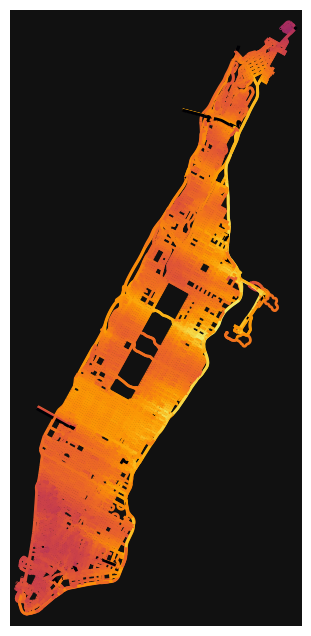

In [17]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [18]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.routing.add_edge_speeds(G)
G = ox.routing.add_edge_travel_times(G)

In [19]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=-122.245846, Y=37.828903)
dest = ox.distance.nearest_nodes(G, X=-122.215006, Y=37.812303)

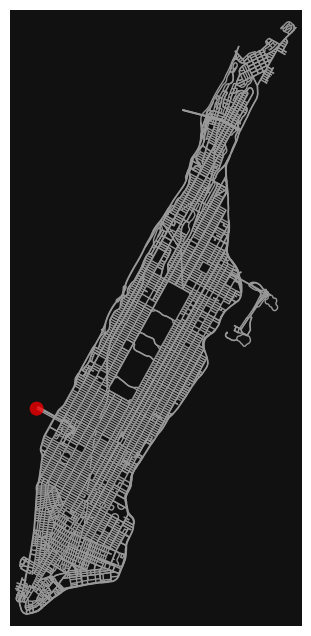

In [20]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.routing.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot.plot_graph_route(G, route, node_size=0)

In [23]:
# how long is our route in meters?
edge_lengths = ox.routing.route_to_gdf(G, route)["length"]
round(sum(edge_lengths))

ValueError: Graph contains no edges.

In [24]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle(orig_y, orig_x, dest_y, dest_x))

0

You can add elevation attributes to your graph's nodes automatically with the `elevation` module, using either local raster files or the Google Maps Elevation API.

In [25]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
try:
    from keys import google_elevation_api_key

    G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
    G = ox.elevation.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
    fig, ax = ox.plot.plot_graph(
        G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333"
    )
except ImportError:
    print("You need a google_elevation_api_key to run this cell.")

You need a google_elevation_api_key to run this cell.


Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

In [ ]:
# you can make query an unambiguous dict to help the geocoder find it
place = {"city": "San Francisco", "state": "California", "country": "USA"}
G = ox.graph.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot.plot_graph(G, figsize=(10, 10), node_size=0, edge_color="y", edge_linewidth=0.2)

In [ ]:
# you can get networks anywhere in the world
G = ox.graph.graph_from_place("Sinalunga, Italy", network_type="all")
fig, ax = ox.plot.plot_graph(G, node_size=0, edge_linewidth=0.5)

In [ ]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609  # meters
G = ox.graph.graph_from_point(wurster_hall, dist=one_mile, network_type="drive")
fig, ax = ox.plot.plot_graph(G, node_size=0)

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

In [ ]:
# get NY subway rail network
G = ox.graph.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

fig, ax = ox.plot.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

## Get any geospatial features' geometries and attributes

Use the `features` module to download any OSM features, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.features). For more usage examples of downloading geospatial features from OSM, see [this notebook](16-download-osm-geospatial-features.ipynb).

In [ ]:
# get all building footprints in some neighborhood
place = "Chinatown, San Francisco, California"
tags = {"building": True}
gdf = ox.features.features_from_place(place, tags)
gdf.shape

In [ ]:
fig, ax = ox.plot.plot_footprints(gdf, figsize=(3, 3))

See the other notebooks for more examples of visualization with OSMnx.

In [ ]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.features.features_from_place(place, tags)
gdf.shape